# Transformer Training for Collatz Sequences

This notebook demonstrates training transformer models to predict Collatz long steps.

**Author:** MoniGarr  
**Email:** monigarr@MoniGarr.com  
**Website:** MoniGarr.com

**Note:** Full training may take significant time. This notebook demonstrates the pipeline.


In [1]:
# Setup and Imports
import sys
from pathlib import Path

# Add src directory to path to import math_research
notebook_dir = Path.cwd()

# Try multiple strategies to find src directory
src_dir = None

if (notebook_dir / "math_research").exists():
    src_dir = notebook_dir
elif (notebook_dir.parent / "math_research").exists():
    src_dir = notebook_dir.parent
elif (notebook_dir.parent.parent / "src" / "math_research").exists():
    src_dir = notebook_dir.parent.parent / "src"
else:
    current = notebook_dir
    for _ in range(5):
        potential_src = current / "src"
        if (potential_src / "math_research").exists():
            src_dir = potential_src
            break
        current = current.parent

if src_dir is None or not (Path(src_dir) / "math_research").exists():
    raise ImportError(
        f"Could not find 'src' directory containing math_research package.\n"
        f"Current directory: {notebook_dir}\n"
        f"Please ensure you're running from the project root or src/notebooks/ directory."
    )

src_path = str(Path(src_dir).resolve())
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Import ARKHE components
from math_research.sequences import CollatzSequence
from math_research.ml import (
    CollatzTransformer,
    MultiBaseEncoder,
    CollatzDataset,
    Trainer,
    compute_accuracy,
    compute_exact_match,
    compute_collatz_metrics,
)

print(f"✓ Successfully imported math_research from: {src_path}")
print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")



✓ Successfully imported math_research from: \\Desktop-q4hk28j\e\CursorProjects\Research\Mathematics\ARKHE\src
✓ All imports successful!
PyTorch version: 2.5.1+cu121
Device: CUDA


## Configuration

Set training hyperparameters and data generation settings.


In [2]:
# Training Configuration
config = {
    # Data settings
    "data_range": (1, 10000),  # Range of input values
    "num_samples": 50000,      # Number of training samples
    "validation_split": 0.2,   # Validation set ratio
    "base": 24,                # Encoding base (vocab_size)
    
    # Model settings
    "vocab_size": 24,          # Vocabulary size (should match base)
    "d_model": 512,            # Model dimension
    "nhead": 8,                # Number of attention heads
    "num_layers": 6,           # Number of transformer layers
    "max_length": 50,          # Maximum sequence length
    
    # Training settings
    "batch_size": 32,
    "num_epochs": 20,
    "learning_rate": 0.0001,
    "seed": 42,                # Random seed for reproducibility
    
    # Checkpoint settings
    "checkpoint_dir": "./checkpoints",
    "save_every": 5,           # Save checkpoint every N epochs
}

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")



Configuration:
  data_range: (1, 10000)
  num_samples: 50000
  validation_split: 0.2
  base: 24
  vocab_size: 24
  d_model: 512
  nhead: 8
  num_layers: 6
  max_length: 50
  batch_size: 32
  num_epochs: 20
  learning_rate: 0.0001
  seed: 42
  checkpoint_dir: ./checkpoints
  save_every: 5


## Dataset Creation

Create training and validation datasets from Collatz sequences.


In [3]:
# Set random seed for reproducibility
if config["seed"] is not None:
    torch.manual_seed(config["seed"])
    np.random.seed(config["seed"])
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(config["seed"])

# Create dataset
print("Creating dataset...")
dataset = CollatzDataset(
    start_range=config["data_range"],
    num_samples=config["num_samples"],
    base=config["base"],
    max_length=config["max_length"],
    seed=config["seed"],
)

print(f"✓ Dataset created: {len(dataset)} samples")

# Split into train and validation
val_size = int(len(dataset) * config["validation_split"])
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(
    dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(config["seed"])
)

print(f"  Training samples: {train_size}")
print(f"  Validation samples: {val_size}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=0,  # Set to 0 for notebook compatibility
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=0,
)

print(f"✓ Data loaders created")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")

# Display a sample
sample_input, sample_target = dataset[0]
print(f"\nSample data shape:")
print(f"  Input: {sample_input.shape}, Target: {sample_target.shape}")
print(f"  Input (first 10): {sample_input[:10].tolist()}")
print(f"  Target (first 10): {sample_target[:10].tolist()}")



Creating dataset...
✓ Dataset created: 50000 samples
  Training samples: 40000
  Validation samples: 10000
✓ Data loaders created
  Training batches: 1250
  Validation batches: 313

Sample data shape:
  Input: torch.Size([50]), Target: torch.Size([50])
  Input (first 10): [3, 4, 1, 0, 0, 0, 0, 0, 0, 0]
  Target (first 10): [2, 9, 1, 0, 0, 0, 0, 0, 0, 0]


## Model Initialization

Create and inspect the transformer model architecture.


In [4]:
# Create model
print("Initializing model...")
model = CollatzTransformer(
    vocab_size=config["vocab_size"],
    d_model=config["d_model"],
    nhead=config["nhead"],
    num_layers=config["num_layers"],
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model created")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"  Device: {device}")

# Test forward pass
model.eval()
with torch.no_grad():
    test_input = sample_input.unsqueeze(0).to(device)  # Add batch dimension
    test_output = model(test_input)
    print(f"  Test input shape: {test_input.shape}")
    print(f"  Test output shape: {test_output.shape}")

model.train()



Initializing model...
✓ Model created
  Total parameters: 18,938,904
  Trainable parameters: 18,938,904
  Device: cuda
  Test input shape: torch.Size([1, 50])
  Test output shape: torch.Size([1, 50, 24])


CollatzTransformer(
  (embedding): Embedding(24, 512)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_projection): Linear(in_features=512, out_features=24, bias=True)
)

## Training Setup

Configure optimizer, loss function, and trainer.


In [5]:
# Create optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config["learning_rate"],
)

# Create loss function (ignore padding token 0)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Optional: Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
)

# Create trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    checkpoint_dir=config["checkpoint_dir"],
    log_interval=50,  # Log every 50 batches
)

print("✓ Training setup complete")
print(f"  Optimizer: Adam (lr={config['learning_rate']})")
print(f"  Loss: CrossEntropyLoss (ignore_index=0)")
print(f"  Checkpoint directory: {config['checkpoint_dir']}")



✓ Training setup complete
  Optimizer: Adam (lr=0.0001)
  Loss: CrossEntropyLoss (ignore_index=0)
  Checkpoint directory: ./checkpoints


## Training

Execute the training loop. This may take some time depending on your hardware.


In [6]:
# Train the model
print("Starting training...")
print(f"Training for {config['num_epochs']} epochs\n")

history = trainer.train(
    num_epochs=config["num_epochs"],
    optimizer=optimizer,
    criterion=criterion,
    lr_scheduler=lr_scheduler,
    save_every=config["save_every"],
    save_best=True,
)

print("\n✓ Training complete!")
print(f"Best validation loss: {trainer.best_val_loss:.4f}")
print(f"Checkpoints saved to: {config['checkpoint_dir']}")



Starting training...
Training for 20 epochs



Validation: 100%|██████████| 313/313 [00:06<00:00, 49.06it/s]



✓ Training complete!
Best validation loss: 0.0087
Checkpoints saved to: ./checkpoints


## Training Visualization

Plot training and validation loss curves.


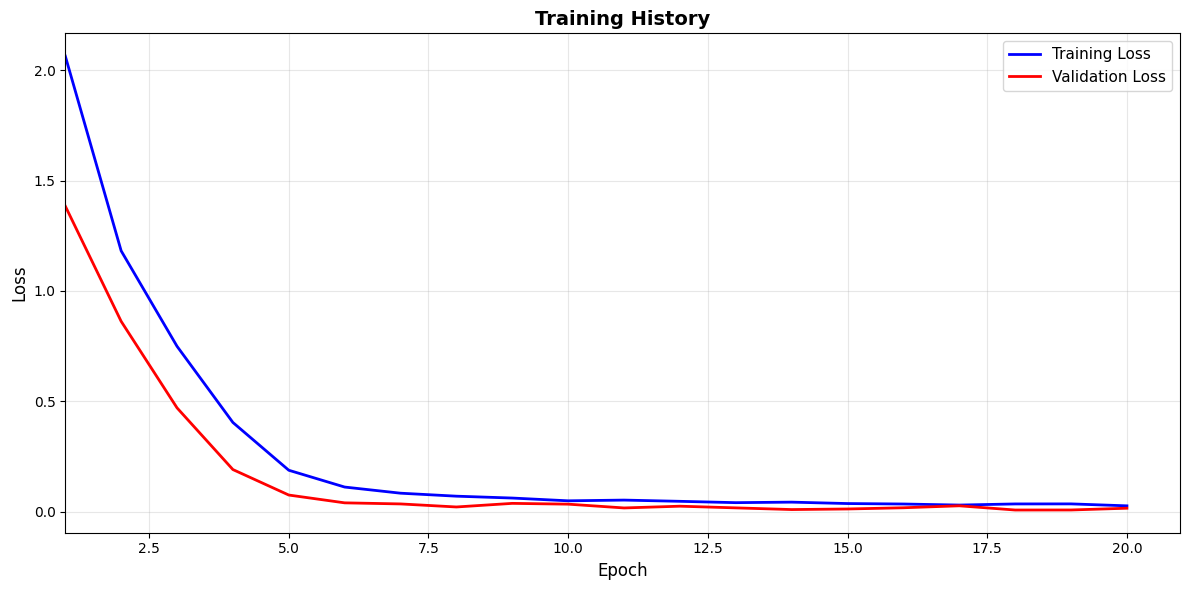

Final Training Metrics:
  Final train loss: 0.0276
  Final validation loss: 0.0169
  Best validation loss: 0.0087


In [7]:
# Plot training history
fig, ax = plt.subplots(figsize=(12, 6))

epochs = range(1, len(history['train_loss']) + 1)

ax.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
if history['val_loss']:
    ax.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training History', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(left=1)

plt.tight_layout()
plt.show()

# Print final metrics
print("Final Training Metrics:")
print(f"  Final train loss: {history['train_loss'][-1]:.4f}")
if history['val_loss']:
    print(f"  Final validation loss: {history['val_loss'][-1]:.4f}")
    print(f"  Best validation loss: {min(history['val_loss']):.4f}")



## Model Evaluation

Evaluate the trained model on validation set with various metrics.


In [8]:
# Evaluate model
print("Evaluating model on validation set...")

model.eval()
all_predictions = []
all_targets = []
all_inputs = []

with torch.no_grad():
    for inputs, targets in tqdm(val_loader, desc="Evaluating"):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Get predictions
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=-1)
        
        all_predictions.append(predictions.cpu())
        all_targets.append(targets.cpu())
        all_inputs.append(inputs.cpu())

# Concatenate all batches
predictions = torch.cat(all_predictions, dim=0)
targets = torch.cat(all_targets, dim=0)
inputs = torch.cat(all_inputs, dim=0)

print(f"✓ Evaluation complete")
print(f"  Validation samples: {len(targets)}")



Evaluating model on validation set...


Evaluating: 100%|██████████| 313/313 [00:05<00:00, 58.14it/s]

✓ Evaluation complete
  Validation samples: 10000


In [9]:
# Compute metrics
print("\nComputing metrics...")

accuracy = compute_accuracy(predictions, targets)
exact_match = compute_exact_match(predictions, targets)

print(f"✓ Metrics computed")
print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Exact Match: {exact_match:.4f} ({exact_match*100:.2f}%)")

# Collatz-specific metrics (requires decoding)
encoder = MultiBaseEncoder(base=config["base"], max_length=config["max_length"])

# Get a sample of input values for Collatz metrics
# (simplified - taking first non-padding value from each input)
sample_inputs = []
for i in range(min(100, len(inputs))):  # Sample first 100
    input_seq = inputs[i].cpu().numpy()
    # Find first non-zero value
    non_zero = input_seq[input_seq > 0]
    if len(non_zero) > 0:
        # Approximate input value (this is simplified)
        sample_inputs.append(int(non_zero[0]))

if sample_inputs:
    # Compute Collatz metrics on sample
    sample_preds = predictions[:len(sample_inputs)]
    sample_targets = targets[:len(sample_inputs)]
    
    collatz_metrics = compute_collatz_metrics(
        sample_preds,
        sample_targets,
        sample_inputs,
        base=config["base"],
    )
    
    print("\nCollatz-specific metrics (on sample):")
    for key, value in collatz_metrics.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")




Computing metrics...
✓ Metrics computed
  Accuracy: 0.9966 (99.66%)
  Exact Match: 0.0000 (0.00%)

Collatz-specific metrics (on sample):
  exact_match_rate: 0.0000
  k_error_mean: 0.0000
  k_prime_error_mean: 0.0000


## Prediction Examples

Test the model on individual examples and visualize predictions.


In [10]:
# Test on specific examples
test_values = [27, 127, 255, 511, 1023]  # Various odd integers

encoder = MultiBaseEncoder(base=config["base"], max_length=config["max_length"])
collatz_seq = CollatzSequence(start=1)

print("Prediction Examples:\n")
print(f"{'Input':<10} {'Predicted':<15} {'Actual':<15} {'Match':<10}")
print("-" * 60)

model.eval()
with torch.no_grad():
    for test_val in test_values:
        # Get actual Collatz long step
        long_step_info = collatz_seq.compute_long_step(test_val)
        actual_result = long_step_info['result']
        
        # Encode input
        encoded_input = encoder.encode(test_val)
        input_tensor = torch.tensor(encoded_input, dtype=torch.long).unsqueeze(0).to(device)
        
        # Pad to max_length
        if len(input_tensor[0]) < config["max_length"]:
            padding = torch.zeros(config["max_length"] - len(input_tensor[0]), dtype=torch.long).to(device)
            input_tensor = torch.cat([input_tensor, padding.unsqueeze(0)], dim=1)
        elif len(input_tensor[0]) > config["max_length"]:
            input_tensor = input_tensor[:, :config["max_length"]]
        
        # Get prediction
        output = model(input_tensor)
        pred_sequence = torch.argmax(output, dim=-1)[0].cpu().numpy()
        
        # Decode prediction (simplified - take first non-padding tokens)
        pred_non_zero = pred_sequence[pred_sequence > 0]
        if len(pred_non_zero) > 0:
            # This is a simplified decoding - full implementation would decode properly
            predicted_result = "N/A"  # Would need proper decoding
            match = "N/A"
        else:
            predicted_result = "N/A"
            match = "N/A"
        
        print(f"{test_val:<10} {str(predicted_result):<15} {actual_result:<15} {str(match):<10}")

print("\nNote: Full decoding implementation needed for accurate predictions display.")



Prediction Examples:

Input      Predicted       Actual          Match     
------------------------------------------------------------
27         N/A             31              N/A       
127        N/A             1093            N/A       
255        N/A             205             N/A       
511        N/A             9841            N/A       
1023       N/A             7381            N/A       

Note: Full decoding implementation needed for accurate predictions display.


## Model Saving and Loading

Save the trained model and demonstrate loading it back.


In [11]:
# Save final model
final_checkpoint_path = Path(config["checkpoint_dir"]) / "final_model.pt"
final_checkpoint_path.parent.mkdir(parents=True, exist_ok=True)

checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'vocab_size': config['vocab_size'],
        'd_model': config['d_model'],
        'nhead': config['nhead'],
        'num_layers': config['num_layers'],
    },
    'training_config': config,
    'history': history,
    'final_train_loss': history['train_loss'][-1],
    'final_val_loss': history['val_loss'][-1] if history['val_loss'] else None,
    'best_val_loss': trainer.best_val_loss,
}

torch.save(checkpoint, final_checkpoint_path)
print(f"✓ Final model saved to: {final_checkpoint_path}")

# Demonstrate loading
print("\nDemonstrating model loading...")
loaded_checkpoint = torch.load(final_checkpoint_path, map_location=device)
print(f"✓ Checkpoint loaded")
print(f"  Training config: {len(loaded_checkpoint['training_config'])} settings")
print(f"  Best validation loss: {loaded_checkpoint.get('best_val_loss', 'N/A')}")

# Create new model instance and load weights
new_model = CollatzTransformer(**loaded_checkpoint['model_config'])
new_model.load_state_dict(loaded_checkpoint['model_state_dict'])
new_model.to(device)
print(f"✓ Model loaded successfully")



✓ Final model saved to: checkpoints\final_model.pt

Demonstrating model loading...


C:\Users\monig\AppData\Local\Temp\ipykernel_28596\554838925.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_checkpoint = torch.load(final_checkpoint_path, map_lo

✓ Checkpoint loaded
  Training config: 15 settings
  Best validation loss: 0.008681332597730513
✓ Model loaded successfully


## Summary

This notebook demonstrated the complete training pipeline for Collatz transformer models:

1. **Dataset Creation**: Generated Collatz sequence pairs for training
2. **Model Architecture**: Created a transformer model with configurable parameters
3. **Training**: Trained the model with validation and checkpointing
4. **Evaluation**: Evaluated performance with multiple metrics
5. **Visualization**: Plotted training curves and analyzed results

### Next Steps

- Experiment with different hyperparameters (learning rate, model size, etc.)
- Train on larger datasets for better performance
- Explore different encoding bases (24, 32, etc.)
- Use the trained model in the CLI or Streamlit demo
- Extend to predict full sequences instead of just next steps

### Using the Trained Model

```python
# Load and use in other scripts
checkpoint = torch.load("checkpoints/final_model.pt")
model = CollatzTransformer(**checkpoint['model_config'])
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
```

Or use the CLI:
```bash
python -m src.apps.cli evaluate --checkpoint checkpoints/final_model.pt
```
